In [1]:
import numpy as np
import itertools as iters
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import scipy

### Load graph 

This script was written by Wenshuo to load the code from the paper
and return a log-density and graph.

In [2]:
%run DCA/treewidth.py

In [3]:
# %load DCA/load_parameters.py
"""
Created on Wed Oct  2 16:21:17 2019

@author: Wenshuo Wang
"""

import scipy.io
import numpy as np
import math
import csv
import networkx as nx
#from treewidth import treewidth_min_fill_in, treewidth_min_degree

keep_const = 0.5 # keep top keep_const*N edges with |i-j|>4
ncondition = 15 # each time condition on ncondition nodes

def Potts_log_density(s, H, J, edges = None, s_condition = None, condition_set = None):
    # P(s0,s1,...,sN-1) \propto exp(\sum_i H[si,i] + \sum_i<j J[i,j,si,sj])
    ans = 0
    L = len(s)
    if condition_set is not None:
        # if conditioning on some set, replace the corresponding variables in s by the ones conditioned on
        for i in condition_set:
            s[i] = s_condition[i]
    for i in range(L):
        ans+= H[int(s[i]),i]
        
    if edges is None:
        for i in range(L-1):
            for j in range(i+1,L):
                ans+= J[i,j,int(s[i]),int(s[j])]
    else:
        for (i,j) in edges:
            ans+= J[i,j,int(s[i]),int(s[j])]
        
    return(ans)
# sample use of the function (run after you run the entire script):
# Potts_log_density(np.array([0]*N),matH,J,np.array([1]*N),set2)
    
mat = scipy.io.loadmat('DCA/J.mat')
mat = mat['J']
q,q,num = np.shape(mat) # q=21 is # residue types
N = int(0.5+math.sqrt(2*num+0.25)) # N is protein length
J = np.zeros([N,N,q,q])
l = 0
for i in range(N-1):
    for j in range(i+1,N):
        J[i,j,:,:] = mat[:,:,l]
        l = l + 1
        

matH = scipy.io.loadmat('DCA/H.mat')
matH = matH['H']

score_metric = np.zeros([int(N*(N-1)/2),3])
k = 0
with open("DCA/PF00006_scores.txt") as scores:
    tem = csv.reader(scores, delimiter=',')
    for row in tem:
        score_metric[k,:] = int(row[0]), int(row[1]), float(row[2])
        k = k + 1

adj_mat = np.zeros([N,N])
score_metric = score_metric[score_metric[:,2].argsort()[::-1]] # sort Jij based on a score
n_keep = math.floor(keep_const*N) # keep how many non-zero Jij, which corresponds to an edge; if graph too dense, decrease this
for i in range(int(N*(N-1)/2)):
	# only the interactions with largest scores (|i-j|>4) are kept, others set to 0
	if n_keep==0:
		J[int(score_metric[i,0])-1,int(score_metric[i,1])-1,:,:] = np.zeros([q,q])
		continue
	else:
		if abs(int(score_metric[i,0])-int(score_metric[i,1]))>4:
			adj_mat[int(score_metric[i,0])-1,int(score_metric[i,1])-1] = 1
			n_keep = n_keep - 1

G = nx.Graph()
G.add_nodes_from(range(N))
for i in range(N-1):
    for j in range(i+1,N):
        if np.sum(J[i,j,:,:]**2)==0:
            pass
        else:
            G.add_edge(i,j)




degrees = np.array([G.degree[i] for i in range(N)])
set1 = degrees.argsort()[-2*ncondition:][::-1]
set2 = np.array([set1[2*i] for i in range(ncondition)])
set1 = np.array([set1[2*i+1] for i in range(ncondition)])
G1 = G.copy()
G1.remove_nodes_from(set1)
G2 = G.copy()
G2.remove_nodes_from(set2)

print("treewidth when keeping "+str(keep_const)+" * N edges: "+str(treewidth_min_fill_in(G)[0]))
print("treewidth when keeping "+str(keep_const)+" * N edges and conditioning on top 2,4,6,...,"+str(2*ncondition)+" max degree nodes: "+str(treewidth_min_fill_in(G1)[0]))
print("treewidth when keeping "+str(keep_const)+" * N edges and conditioning on top 1,3,5,...,"+str(2*ncondition-1)+" max degree nodes: "+str(treewidth_min_fill_in(G2)[0]))



treewidth when keeping 0.5 * N edges: 5
treewidth when keeping 0.5 * N edges and conditioning on top 2,4,6,...,30 max degree nodes: 3
treewidth when keeping 0.5 * N edges and conditioning on top 1,3,5,...,29 max degree nodes: 3


## Density and Sampler

In [4]:
np.shape(matH)

(21, 213)

In [5]:
np.shape(J)

(213, 213, 21, 21)

In [6]:
edges = list(G.edges())

In [7]:
def lf(x):
    return 5*Potts_log_density(x, matH, J, edges, s_condition = None, condition_set = None)

In [8]:
lf(np.zeros(213))

204.82858281799548

In [9]:
import matplotlib.pyplot as plt

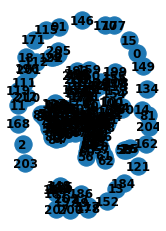

In [10]:
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')

In [11]:
def gibbs_sampler(lf, d, n_iter = 50):
    x_init = np.random.choice(21, size = d)
    #x_init = 10*np.ones(d)
    x = x_init.copy()
    p_orig = np.exp(lf(x))
    
    lfs = [np.log(p_orig)]
    
    for _ in range(n_iter): 
        j = np.random.choice(d)
        orig = x[j]
        
        #metropolis update with uniformly random proposal
        prop = np.random.choice(21, size = 1)
        if prop == orig:
            continue      
        x[j] = prop
        p_prop = np.exp(lf(x))          
        accept_prob = min(1, p_prop / p_orig)
        u = np.random.uniform()
        if(u < accept_prob):
            p_orig = p_prop
            lfs += [np.log(p_prop)]
        else:
            x[j] = orig
            lfs += [np.log(p_orig)]
    
    return [x, x_init, lfs]

In [12]:
%%time
np.random.seed(500)

x, x_init, lfs = gibbs_sampler(lf, 213, n_iter = 20000)

CPU times: user 8.62 s, sys: 87.8 ms, total: 8.71 s
Wall time: 10.3 s


In [13]:
np.sum(x != x_init)

205

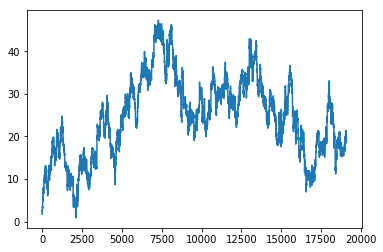

In [14]:
fig = plt.figure()
ax = plt.axes()
ax.plot(np.arange(len(lfs)), lfs);

## Ordered Metro

Extract an ordering from the junction tree of the graph G.

In [15]:
%run metro_generic.py

In [16]:
tree_decomp = treewidth_decomp(G)

In [17]:
tree_decomp[0]

5

In [18]:
T = tree_decomp[1]

In [19]:
T.number_of_nodes()

208

In [20]:
G.number_of_nodes()

213

In [21]:
#extract a variable ordering and set of active nodes from a junction tree
def get_ordering(T):
    T = T.copy()
    order = []
    active_frontier = []
    
    while(T.number_of_nodes() > 0):
        gen = (x for x in T.nodes() if T.degree(x) <= 1)
        active_node = next(gen)
        parents = list(T[active_node].keys())
        if(len(parents) == 0):
            active_vars = set(active_node)
            activated_set = active_vars.copy()
        else:
            active_vars = set(active_node.difference(parents[0]))
            activated_set = active_vars.union(parents[0]).difference(set(order))
        for i in active_vars:
            order += [i]
            frontier = list(activated_set.difference(set(order)))
            active_frontier += [frontier]
        T.remove_node(active_node)
    
    return [np.array(order), active_frontier]
            

In [22]:
order, active_frontier = get_ordering(T)

In [23]:
active_frontier[0]

[32, 36, 31]

In [24]:
print(len(order))
print(len(active_frontier))
print(set(order))
print(len(set(order)))

213
213
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212}
213


In [25]:
#re-ordered active frontier
inv_order = order.copy()
for i, j in enumerate(order):
    inv_order[j] = i

active_frontier2 = []
for i in range(len(order)):
    active_frontier2 += [[inv_order[j] for j in active_frontier[i]]]

In [26]:
active_frontier2

[[129, 130, 86],
 [199, 201, 200, 198],
 [199, 201, 200, 198],
 [5, 111],
 [73, 201, 203, 204],
 [111, 112],
 [209, 210, 212],
 [190, 188, 189],
 [159, 160],
 [190, 187, 188, 189],
 [199, 201, 200, 198],
 [199, 201, 200, 198],
 [199, 201, 200, 198],
 [190, 187, 186, 189],
 [139, 140, 208],
 [95, 16],
 [95, 177],
 [69, 70, 161, 71],
 [199, 201, 200, 198],
 [125, 123, 124],
 [92],
 [209, 210, 212],
 [199, 201, 200, 198],
 [101],
 [199, 201, 200, 198],
 [196, 81, 168],
 [131, 161, 127, 193],
 [125, 123, 124],
 [30, 29],
 [30, 65],
 [65, 100],
 [199, 201, 200, 198],
 [68, 67, 69],
 [199, 201, 200, 198],
 [131, 192, 35],
 [131, 161, 192, 193],
 [61],
 [199, 201, 200, 198],
 [195, 166, 203],
 [199, 201, 200, 198],
 [42, 41],
 [42, 194, 70],
 [194, 161, 70, 71],
 [199, 201, 200, 198],
 [63, 62],
 [199, 201, 200, 198],
 [205, 181, 78, 201],
 [199, 201, 200, 198],
 [199, 201, 200, 198],
 [115, 170, 149],
 [51, 52],
 [53, 52],
 [53],
 [199, 201, 200, 198],
 [55, 164, 165],
 [164, 165],
 [177, 17

In [27]:
for i in range(len(active_frontier2)):
    print(i, min(active_frontier2[i]))

0 86
1 198
2 198
3 5
4 73
5 111
6 209
7 188
8 159
9 187
10 198
11 198
12 198
13 186
14 139
15 16
16 95
17 69
18 198
19 123
20 92
21 209
22 198
23 101
24 198
25 81
26 127
27 123
28 29
29 30
30 65
31 198
32 67
33 198
34 35
35 131
36 61
37 198
38 166
39 198
40 41
41 42
42 70
43 198
44 62
45 198
46 78
47 198
48 198
49 115
50 51
51 52
52 53
53 198
54 55
55 164
56 176
57 198
58 126
59 60
60 148
61 198
62 63
63 86
64 77
65 100
66 67
67 68
68 69
69 70
70 71
71 161
72 198
73 201
74 106
75 76
76 91
77 78
78 181
79 80
80 198
81 168
82 184
83 198
84 159
85 196
86 129
87 198
88 89
89 205
90 91
91 156
92 198
93 172
94 198
95 176
96 97
97 98
98 99
99 151
100 198
101 198
102 103
103 127
104 105
105 183
106 107
107 138
108 198
109 110
110 118
111 112
112 113
113 114
114 146
115 149
116 198
117 198
118 198
119 120
120 138
121 198
122 123
123 124
124 125
125 191
126 127
127 131
128 129
129 130
130 148
131 161
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144


ValueError: min() arg is an empty sequence

In [28]:
print(len(active_frontier2))
print(max(len(i) for i in active_frontier2))

213
6


In [29]:
max_deg = 0
max([len(list(x)) for x in T.nodes()])

6

In [30]:
def sym_proposal(j, xj):
    return np.random.choice(21)

In [31]:
%run metro_generic.py

In [32]:
%%time
np.random.seed(100)

xk = single_metro(lf, x, order, active_frontier, sym_proposal)

CPU times: user 2.48 s, sys: 6.91 ms, total: 2.48 s
Wall time: 2.49 s


In [33]:
%%time
np.random.seed(20000)
x, _, _ = gibbs_sampler(lf, 213, n_iter = 20000)
xk = single_metro(lf, x, order, active_frontier, sym_proposal)

CPU times: user 10.6 s, sys: 111 ms, total: 10.7 s
Wall time: 10.7 s


In [34]:
np.mean(x == xk)

0.3192488262910798

In [35]:
1 / 21 #fraction of matches of uniform iid  setting

0.047619047619047616

In [36]:
np.mean(np.abs(x - xk))

5.122065727699531

In [37]:
x

array([16, 11,  7, 10, 18,  4, 14,  3, 17,  5, 15,  6, 19, 17, 19, 19, 13,
        6,  3,  5, 17, 12, 17, 15,  8, 18, 20, 16, 16, 18,  1, 17,  4,  1,
        8,  7, 12, 16,  1, 18,  3,  0,  8,  5,  8, 20,  1,  8,  8,  6,  8,
        1,  4,  9,  7, 13,  0,  9, 13,  7, 17,  7,  4,  7,  1,  4,  1,  0,
        0,  0,  0,  7,  2,  7,  5,  0,  8,  0,  0, 17,  2, 20,  7, 10,  5,
        9, 18,  2, 11, 20, 15,  9,  1, 15, 19, 10,  6,  5, 20,  5, 15,  3,
       14, 18,  9, 13,  9,  0,  5, 18, 17, 11,  7,  9, 17, 12, 18, 12,  9,
        7, 18,  7,  2, 19, 11, 12,  3, 11, 20,  5, 16, 16,  6, 11, 17,  6,
        0,  0,  0,  0,  5, 18, 10,  3, 13,  5, 12, 11, 18,  7,  9,  8, 17,
        0,  6, 14, 16, 14, 12, 14,  5, 10,  1, 12, 12,  6,  4, 13,  3, 10,
       18, 15,  3, 19, 17,  0,  7, 11,  8,  1,  6, 16, 16,  0, 17,  1, 16,
       10, 15,  0,  8, 18,  6, 12,  1, 10,  5,  3,  8,  3, 12, 16,  4, 20,
        1, 18,  9, 10,  7, 14,  6,  6, 20])

In [38]:
xk

array([ 5, 11, 12, 10,  2, 16,  1, 18,  3, 14,  7,  5,  0, 17, 15, 15,  4,
        6,  4,  5, 17, 12, 20, 20,  2, 13, 16,  4, 16, 18,  1, 17,  4, 12,
        8,  7, 12, 14, 15,  5,  3,  0,  8,  5,  8, 19,  1,  8, 14, 20, 14,
       12, 11,  6,  7,  9,  3, 18, 13,  7,  3, 19, 13, 12, 11,  2, 12,  0,
        0,  0,  0,  0,  2,  8, 11, 19, 13,  0,  0,  0,  7, 12, 14, 10,  3,
       17, 11, 11, 20, 13, 15, 18,  1,  6, 19, 10,  6, 17, 20,  5, 15,  3,
       14, 14,  8,  4,  9,  2,  5, 18,  9, 14, 18, 17,  6,  8, 20, 18,  9,
       18, 18, 13, 15, 18, 19, 20,  9,  8, 12, 16, 18, 15,  4, 14,  3,  6,
        0,  0,  0,  0, 20,  5, 14,  3, 18,  0, 16, 16,  3, 10,  5, 17, 20,
        4,  6, 14,  8, 14, 13, 17,  6, 10,  1,  7,  6, 20, 16,  3, 17, 10,
        4, 13,  3, 12, 12, 12, 12, 17, 12,  6, 18, 10,  3,  0, 11, 16,  2,
        3, 15,  0, 13, 18, 19,  4, 20, 19,  8, 11, 13, 10, 12, 16, 17, 12,
        5, 17,  9, 16,  9,  0, 10, 14, 18])

In [39]:
x - xk

array([ 11,   0,  -5,   0,  16, -12,  13, -15,  14,  -9,   8,   1,  19,
         0,   4,   4,   9,   0,  -1,   0,   0,   0,  -3,  -5,   6,   5,
         4,  12,   0,   0,   0,   0,   0, -11,   0,   0,   0,   2, -14,
        13,   0,   0,   0,   0,   0,   1,   0,   0,  -6, -14,  -6, -11,
        -7,   3,   0,   4,  -3,  -9,   0,   0,  14, -12,  -9,  -5, -10,
         2, -11,   0,   0,   0,   0,   7,   0,  -1,  -6, -19,  -5,   0,
         0,  17,  -5,   8,  -7,   0,   2,  -8,   7,  -9,  -9,   7,   0,
        -9,   0,   9,   0,   0,   0, -12,   0,   0,   0,   0,   0,   4,
         1,   9,   0,  -2,   0,   0,   8,  -3, -11,  -8,  11,   4,  -2,
        -6,   0, -11,   0,  -6, -13,   1,  -8,  -8,  -6,   3,   8, -11,
        -2,   1,   2,  -3,  14,   0,   0,   0,   0,   0, -15,  13,  -4,
         0,  -5,   5,  -4,  -5,  15,  -3,   4,  -9,  -3,  -4,   0,   0,
         8,   0,  -1,  -3,  -1,   0,   0,   5,   6, -14, -12,  10, -14,
         0,  14,   2,   0,   7,   5, -12,  -5,  -6,  -4,  -5, -1

## Parallel Simulation

In [40]:
import multiprocessing as mp
from joblib import Parallel, delayed
import pickle

In [41]:
def sample():
    x, _, _ = gibbs_sampler(lf, 213, n_iter = 20000)
    xk = single_metro(lf, x, order, active_frontier, sym_proposal)
    
    return [x, xk]

In [42]:
%%time
x, xk = sample()
np.mean(x == xk)

CPU times: user 10.5 s, sys: 99 ms, total: 10.6 s
Wall time: 10.6 s


0.15492957746478872

In [43]:
%%time
results = Parallel(n_jobs=2)(delayed(sample)() for i in range(4))

CPU times: user 693 ms, sys: 722 ms, total: 1.42 s
Wall time: 26.1 s


In [194]:
%%time
results = [sample() for i in range(6)]

CPU times: user 1min 3s, sys: 492 ms, total: 1min 4s
Wall time: 1min 4s


In [ ]:
%%time
n_samples = 500
results = Parallel(n_jobs=2)(delayed(sample)() for i in range(n_samples))

In [195]:
for x, xk in results:
    print(np.mean(x == xk))
    print(np.mean(np.abs(x - xk)))

0.29577464788732394
5.145539906103286
0.29107981220657275
5.356807511737089
0.27699530516431925
5.544600938967136
0.2676056338028169
5.042253521126761
0.323943661971831
4.915492957746479
0.323943661971831
4.995305164319249


In [48]:
len(results)

100

In [49]:
pickle.dump(results, open("sim_results.p", "wb"))
#results = pickle.load(open("sim_results.p", "rb"))

In [50]:
x = np.zeros((len(results), 2*len(results[0][0])))
for i, row in enumerate(results):
    x[i,:] = np.concatenate((row[0], row[1]))

In [51]:
np.mean(x[:, 0:213] == x[:, 213:])

0.27

In [52]:
emp_cov = np.cov(x, rowvar=False)

In [53]:
np.mean(np.abs(emp_cov[0:213, 0:213] - emp_cov[213:426, 213:426]) / 
        (np.abs(emp_cov[0:213, 0:213]) + np.abs(emp_cov[213:426, 213:426])))

0.7074105535346306

In [54]:
import seaborn as sns

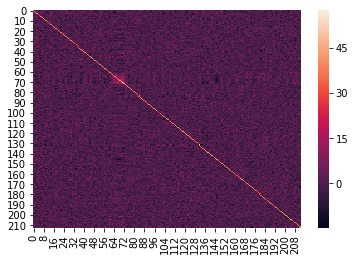

In [55]:
sns.heatmap(emp_cov[0:213, 0:213])

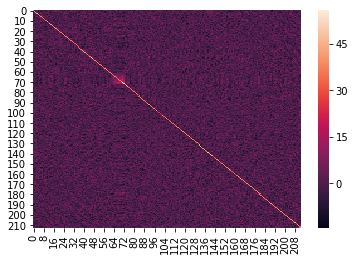

In [56]:
sns.heatmap(emp_cov[213:, 213:])